In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker


In [3]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=True)

Shuffling and writing examples to data/fashion_mnist/3.0.1.incomplete8W7U20/fashion_mnist-train.tfrecord


Shuffling and writing examples to data/fashion_mnist/3.0.1.incomplete8W7U20/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
def format_data(data):
    im = data['image']
    im = tf.reshape(im, [-1])
    im = tf.cast(im, 'float32')
    im = im /255.0
    return im, data['label']

In [7]:
train_data = train_data.map(format_data)
test_data = test_data.map(format_data)

In [8]:
bs =64
train = train_data.shuffle(buffer_size = 1024).batch(bs)

In [9]:
test = test_data.batch(batch_size = bs)

# Getting one Batch data

In [12]:
data, label = next(iter(train))

In [13]:
data.shape

TensorShape([64, 784])

# Model

In [19]:
def Model_get():
    inputs = Input(shape= (784,), name = 'digits')
    x = Dense(64,activation = 'relu', name = 'dense_1')(inputs)
    x = Dense(64, activation = 'relu', name = 'dense_2')(x)
    out = Dense(10, activation = 'softmax', name = 'prediction')(x)
    mod = Model(inputs= inputs, outputs = out)
    return mod

In [20]:
model= Model_get()

# Loss and optimizer

In [15]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam()

# Metrics 

In [16]:
trn_metric = tf.keras.metrics.SparseCategoricalAccuracy()
tst_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Training loop

we have 64 images in one batch. So trianinig loop contains
 1. apply gradient to one image and continue it for whole batch in a loop
 2. create loss for that batch and maybe accuracy for that batch 
 3. create loss for all batches i.e one epochs
 4. continue for all epochs
 5. at the end of all epochs see model accuracy
 6. again continue with 1

In [47]:
def Gradient_cal(optimizers, y_act, inputs, model):
    with tf.GradientTape() as Tape:
        logits = model(inputs)
        pr_loss = loss_obj(y_act, logits)
    gradients = Tape.gradient(pr_loss,model.trainable_weights)
    optimizers.apply_gradients(zip(gradients, model.trainable_weights))
    return logits, pr_loss

Psudo training loop will be then


```python
def training_loop(all_data_batches) 
for batch in all_data_batches:
    for image in batch
        logits, loss = Gradient_cal(image)
        
```       

In [48]:

def train_one_epoch():
    loss_list =[]
    pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for batch,(img_batch, lbl_batch) in enumerate(train):
        logits, loss = Gradient_cal(opt, lbl_batch, img_batch, model)
        loss_list.append(loss)
        trn_metric(lbl_batch, logits)
        
        pbar.set_description(f'Training loss for batch {int(batch)} is = {float(loss):.4f}')
        pbar.update()
    return loss_list

In [49]:
def mod_evl():
    val_loss  =[]

    for x_val, y_val in test:
        val_logits = model(x_val)
        loss_ = loss_obj(y_val, val_logits)
        val_loss.append(loss_)
        tst_metric(y_val,val_logits)
        
    return val_loss

In [52]:
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
    print(f'Start of epoch {epoch,}')
  
    losses_train = train_one_epoch()
    train_acc = trn_metric.result()
    
    losses_val = mod_evl()
    val_acc = tst_metric.result()
    
    #previously it was for all batches but we need mean
    
    loss_trn = np.mean(losses_train)
    epochs_train_losses.append(loss_trn)
    
    
    loss_val = np.mean(losses_val)
    
    epochs_val_losses.append(loss_val)
    
    print(f'\n Epoch {epoch}: Train loss = {float(loss_trn):.4f}, Validation Loss: {float(loss_val):.4f}, Train Accuracy: {float(train_acc):.4f}, Validation Accuracy: {float(val_acc):.4f}') 
  

Start of epoch (0,)


Training loss for step 937 is = 0.2281: 100%|██████████| 938/938 
Training loss for step 937 is = 0.3560: 100%|██████████| 938/938 



 Epoch 0: Train loss = 0.2263, Validation Loss: 0.3590, Train Accuracy: 0.8896, Validation Accuracy: 0.8745
Start of epoch (1,)


Training loss for step 937 is = 0.0730: 100%|█████████▉| 937/938 


 Epoch 1: Train loss = 0.2195, Validation Loss: 0.3802, Train Accuracy: 0.8913, Validation Accuracy: 0.8748
Start of epoch (2,)


Training loss for step 937 is = 0.0730: 100%|██████████| 938/938 
Training loss for step 937 is = 0.1164: 100%|██████████| 938/938 


 Epoch 2: Train loss = 0.2155, Validation Loss: 0.3612, Train Accuracy: 0.8929, Validation Accuracy: 0.8750
Start of epoch (3,)



Training loss for step 937 is = 0.1489: 100%|█████████▉| 937/938 


 Epoch 3: Train loss = 0.2110, Validation Loss: 0.3815, Train Accuracy: 0.8945, Validation Accuracy: 0.8755
Start of epoch (4,)


Training loss for step 937 is = 0.1138: 100%|█████████▉| 937/938 


 Epoch 4: Train loss = 0.2055, Validation Loss: 0.3534, Train Accuracy: 0.8960, Validation Accuracy: 0.8763
Start of epoch (5,)


Training loss for step 937 is = 0.1138: 100%|██████████| 938/938 
Training loss for step 937 is = 0.2760: 100%|██████████| 938/938 


 Epoch 5: Train loss = 0.2021, Validation Loss: 0.3661, Train Accuracy: 0.8974, Validation Accuracy: 0.8767
Start of epoch (6,)



Training loss for step 937 is = 0.0839: 100%|█████████▉| 937/938 


 Epoch 6: Train loss = 0.1969, Validation Loss: 0.3738, Train Accuracy: 0.8988, Validation Accuracy: 0.8769
Start of epoch (7,)


Training loss for step 937 is = 0.1963: 100%|█████████▉| 937/938 


 Epoch 7: Train loss = 0.1931, Validation Loss: 0.3786, Train Accuracy: 0.9001, Validation Accuracy: 0.8772
Start of epoch (8,)


Training loss for step 937 is = 0.1963: 100%|██████████| 938/938 
Training loss for step 937 is = 0.2750: 100%|██████████| 938/938 


 Epoch 8: Train loss = 0.1903, Validation Loss: 0.3733, Train Accuracy: 0.9013, Validation Accuracy: 0.8776
Start of epoch (9,)



Training loss for step 937 is = 0.0880: 100%|█████████▉| 937/938 


 Epoch 9: Train loss = 0.1860, Validation Loss: 0.3724, Train Accuracy: 0.9025, Validation Accuracy: 0.8781


Training loss for step 937 is = 0.0880: 100%|██████████| 938/938 

In [53]:
test = test_data.batch(batch_size = 100001)

In [57]:
for image, label in test:
    y_pred = model(image)
    y_pred_np = y_pred.numpy()
    
    y_act_np = label.numpy()
    
    x_np = image.numpy()

In [59]:
x_np.shape

(10000, 784)

In [63]:
indexes = np.random.choice(len(label), size = 10)
np.random.choice(len(label), size = 10)

array([6471, 7322, 6547, 4060, 8491,  929, 5704, 6515, 7076, 4272])

In [68]:
images_for_plot = x_np[indexes]
label_for_plt_image = y_act_np[indexes]
prd_for_plt_image = y_pred_np[indexes]

At present labels are generally numbers, we need to somehow change those numbers to text so that in the image the text will be visible

In [69]:
label_for_plt_image

array([1, 0, 3, 4, 3, 5, 3, 1, 8, 2])

In [70]:
prd_for_plt_image

array([[2.9434298e-06, 9.9992096e-01, 2.0198875e-08, 7.2174516e-05,
        2.2392090e-08, 3.1039706e-11, 3.8998605e-06, 3.1193835e-15,
        2.4619988e-11, 9.7443610e-15],
       [6.6268170e-01, 3.7050607e-09, 1.9506870e-06, 1.8092982e-07,
        6.0800295e-07, 1.0034400e-14, 3.3731562e-01, 2.7578130e-17,
        2.5204791e-10, 3.7185752e-13],
       [1.9245394e-04, 4.0494987e-07, 6.9955694e-03, 9.3789208e-01,
        4.0158462e-02, 6.5916419e-07, 1.4755718e-02, 4.9685595e-10,
        8.8649153e-07, 3.7154994e-06],
       [8.6790733e-06, 2.0930910e-08, 2.7245650e-02, 4.6955415e-07,
        9.6496350e-01, 2.7432045e-12, 7.7816299e-03, 1.2859673e-11,
        6.3286770e-08, 1.6081363e-10],
       [1.1504063e-06, 6.9773846e-06, 5.1408482e-04, 9.9852544e-01,
        6.6753576e-04, 5.8380927e-09, 2.8471259e-04, 1.7885809e-13,
        1.0506032e-08, 5.9556267e-08],
       [7.0278762e-11, 3.1878996e-16, 4.9426067e-11, 1.2855338e-13,
        5.2520429e-11, 1.0000000e+00, 2.0376807e-09, 2.26

we need to use ``np.argmax`` for prediction

In [71]:
[np.argmax(i) for i in prd_for_plt_image]

[1, 0, 3, 4, 3, 5, 3, 1, 8, 2]

In [72]:
class_names

['T-shirt/top',
 'Trouser/pants',
 'Pullover shirt',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [75]:
pred_labels = [class_names[np.argmax(i)] for i in prd_for_plt_image]
act_labels = [class_names[i] for i in label_for_plt_image]

In [95]:
strings_to_display = [f'pred:{y_pred}\n\n act:{y_act}'for y_pred, y_act in zip(pred_labels, act_labels)]
strings_to_display

['pred:Trouser/pants\n\n act:Trouser/pants',
 'pred:T-shirt/top\n\n act:T-shirt/top',
 'pred:Dress\n\n act:Dress',
 'pred:Coat\n\n act:Coat',
 'pred:Dress\n\n act:Dress',
 'pred:Sandal\n\n act:Sandal',
 'pred:Dress\n\n act:Dress',
 'pred:Trouser/pants\n\n act:Trouser/pants',
 'pred:Bag\n\n act:Bag',
 'pred:Pullover shirt\n\n act:Pullover shirt']

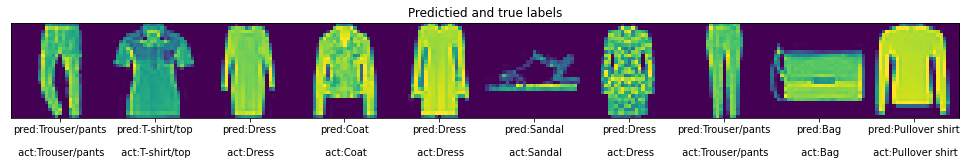

In [99]:
plt.figure(figsize=(17,3))
image = np.reshape(images_for_plot,[10,28,28])
image = np.swapaxes(image,0,1)
image = np.reshape(image, [28, 28*10])
plt.imshow(image)
plt.title('Predictied and true labels');
plt.yticks([])
plt.xticks([28*x+14 for x in range(10)], strings_to_display);

In [101]:
def display_n_images(images, predictions, labels, title, n):
    strings_to_display = [f'pred:{y_pred}\n\n act:{y_act}'for y_pred, y_act in zip(predictions, labels)]
    plt.figure(figsize=(17,3))
    
    image = np.reshape(images,[n,28,28])
    image = np.swapaxes(image,0,1)
    image = np.reshape(image, [28, 28*n])
    plt.imshow(image)
    plt.title('Predictied and true labels');
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], strings_to_display);

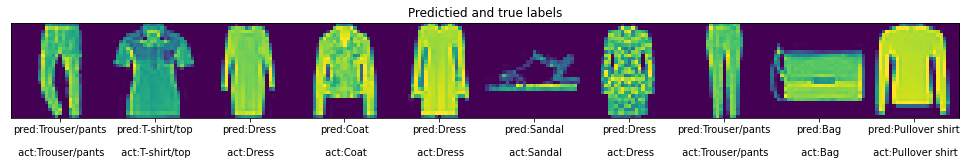

In [107]:
display_n_images(images_for_plot,pred_labels,act_labels,'predict vs actual',10)

In [108]:
def display_random_test_image(test, number):
    test = test_data.batch(batch_size = 100001)
    
    for image, label in test:
        y_pred = model(image)
        y_pred_np = y_pred.numpy()

        y_act_np = label.numpy()

        x_np = image.numpy()
    indexes = np.random.choice(len(label), size = number)
    np.random.choice(len(label), size = number)
    
    
    images_for_plot = x_np[indexes]
    label_for_plt_image = y_act_np[indexes]
    prd_for_plt_image = y_pred_np[indexes]
    
    pred_labels = [class_names[np.argmax(i)] for i in prd_for_plt_image]
    act_labels = [class_names[i] for i in label_for_plt_image]
    
    
    strings_to_display = [f'pred:{y_pred}\n\n act:{y_act}'for y_pred, y_act in zip(pred_labels, act_labels)]
    
    
    display_n_images(images_for_plot, pred_labels, act_labels, 'nice', number)

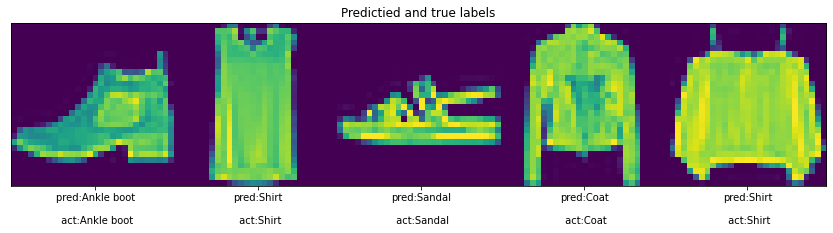

In [110]:
display_random_test_image(test, 5)